In [32]:
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.decomposition import PCA

from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential

In [2]:
data_train = pd.read_excel('Data_Train.xlsx')
data_test = pd.read_excel('Data_Test.xlsx')
print(f'Training Data: {data_train.shape}, Test Data: {data_test.shape}')

data = pd.concat([data_train, data_test])
print(f'Concatenated Data: {data.shape}')
data.head()

Training Data: (6019, 13), Test Data: (1234, 12)
Concatenated Data: (7253, 13)


,Engine,Fuel_Type,Kilometers_Driven,Location,Mileage,Name,New_Price,Owner_Type,Power,Price,Seats,Transmission,Year
0,998 CC,CNG,72000,Mumbai,26.6 km/kg,Maruti Wagon R LXI CNG,NaN,First,58.16 bhp,1.75,5.0,Manual,2010
1,1582 CC,Diesel,41000,Pune,19.67 kmpl,Hyundai Creta 1.6 CRDi SX Option,NaN,First,126.2 bhp,12.50,5.0,Manual,2015
2,1199 CC,Petrol,46000,Chennai,18.2 kmpl,Honda Jazz V,8.61 Lakh,First,88.7 bhp,4.50,5.0,Manual,2011
3,1248 CC,Diesel,87000,Chennai,20.77 kmpl,Maruti Ertiga VDI,NaN,First,88.76 bhp,6.00,7.0,Manual,2012
4,1968 CC,Diesel,40670,Coimbatore,15.2 kmpl,Audi A4 New 2.0 TDI Multitronic,NaN,Second,140.8 bhp,17.74,5.0,Automatic,2013


In [3]:
training_data_len = 6019

# Basic Featurizations

In [4]:
data['Power'] = data['Power'].apply(lambda x: np.nan if (type(x) is not float) and ('null' in x) else x)

In [5]:
data['Car_Company'] = data['Name'].progress_apply(lambda x: x.split()[0])
data['Car_Name'] = data['Name'].progress_apply(lambda x: ' '.join(x.split()[1:]))
data['Car_Mileage'] = data['Mileage'].progress_apply(lambda x: x.split()[0] if x is not np.nan else x).astype(np.float64)
data['Car_Engine'] = data['Engine'].progress_apply(lambda x: x.split()[0] if x is not np.nan else x).astype(np.float64)
data['Car_Power'] = data['Power'].progress_apply(lambda x: x.split()[0] if x is not np.nan else x).astype(np.float64)

100%|██████████████████████████████████████████████████████████████████████████| 7253/7253 [00:00<00:00, 286347.64it/s]


In [6]:
data['New_Price'][data['New_Price'].notnull()].apply(lambda x: x.split()[1]).unique()

array(['Lakh', 'Cr'], dtype=object)

In [7]:
def get_price(price):
    if price is np.nan:
        return price
#     numerals = {'Lakh': 10**5, 'Cr':10**7}
    num, numeral = float(price.split()[0]), price.split()[1]
    if numeral == 'Cr':
        return num*100
    else:
        return num

data['Car_New_Price'] = data['New_Price'].apply(get_price).astype(np.float)

In [8]:
data.head()

,Engine,Fuel_Type,Kilometers_Driven,Location,Mileage,Name,New_Price,Owner_Type,Power,Price,Seats,Transmission,Year,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,998 CC,CNG,72000,Mumbai,26.6 km/kg,Maruti Wagon R LXI CNG,NaN,First,58.16 bhp,1.75,5.0,Manual,2010,Maruti,Wagon R LXI CNG,26.60,998.0,58.16,NaN
1,1582 CC,Diesel,41000,Pune,19.67 kmpl,Hyundai Creta 1.6 CRDi SX Option,NaN,First,126.2 bhp,12.50,5.0,Manual,2015,Hyundai,Creta 1.6 CRDi SX Option,19.67,1582.0,126.20,NaN
2,1199 CC,Petrol,46000,Chennai,18.2 kmpl,Honda Jazz V,8.61 Lakh,First,88.7 bhp,4.50,5.0,Manual,2011,Honda,Jazz V,18.20,1199.0,88.70,8.61
3,1248 CC,Diesel,87000,Chennai,20.77 kmpl,Maruti Ertiga VDI,NaN,First,88.76 bhp,6.00,7.0,Manual,2012,Maruti,Ertiga VDI,20.77,1248.0,88.76,NaN
4,1968 CC,Diesel,40670,Coimbatore,15.2 kmpl,Audi A4 New 2.0 TDI Multitronic,NaN,Second,140.8 bhp,17.74,5.0,Automatic,2013,Audi,A4 New 2.0 TDI Multitronic,15.20,1968.0,140.80,NaN


# Exploratory Data Analysis

In [535]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 19 columns):
Name                 6018 non-null object
Location             6018 non-null object
Year                 6018 non-null int64
Kilometers_Driven    6018 non-null int64
Fuel_Type            6018 non-null object
Transmission         6018 non-null object
Owner_Type           6018 non-null object
Mileage              6016 non-null object
Engine               5982 non-null object
Power                5875 non-null object
Seats                5976 non-null float64
New_Price            824 non-null object
Price                6018 non-null float64
Car_Company          6018 non-null object
Car_Name             6018 non-null object
Car_Mileage          6016 non-null float64
Car_Engine           5982 non-null float64
Car_Power            5875 non-null float64
Car_New_Price        824 non-null float64
dtypes: float64(6), int64(2), object(11)
memory usage: 1.1+ MB


In [125]:
for i in data.columns:
    print(f'Column: {i} --> {data[i].isnull().sum()}')

Column: Name --> 0
Column: Location --> 0
Column: Year --> 0
Column: Kilometers_Driven --> 0
Column: Fuel_Type --> 0
Column: Transmission --> 0
Column: Owner_Type --> 0
Column: Mileage --> 2
Column: Engine --> 36
Column: Power --> 143
Column: Seats --> 42
Column: New_Price --> 5195
Column: Price --> 0
Column: Car_Company --> 0
Column: Car_Name --> 0
Column: Car_Mileage --> 2
Column: Car_Engine --> 36
Column: Car_Power --> 143


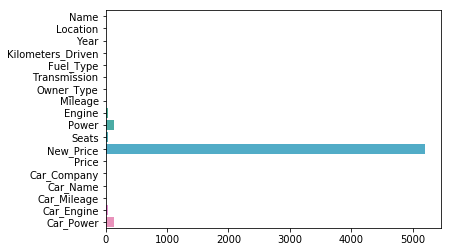

In [163]:
sns.barplot(y=data.columns, x=data.isnull().sum())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

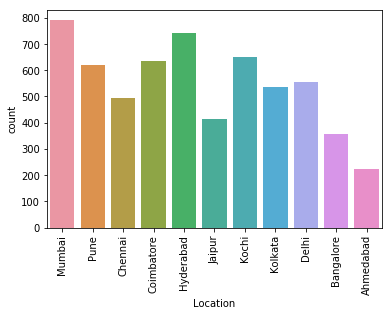

In [127]:
sns.countplot(data.Location)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

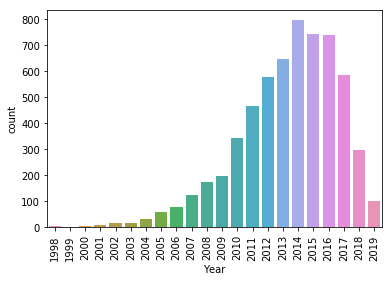

In [128]:
sns.countplot(data.Year)
plt.xticks(rotation=90)

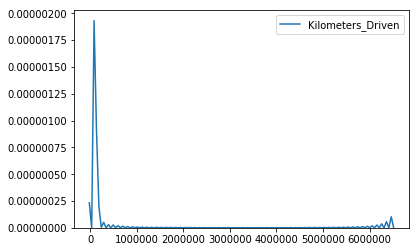

In [154]:
sns.kdeplot(data.Kilometers_Driven)

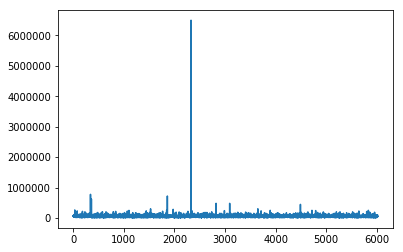

In [129]:
data.Kilometers_Driven.plot()

In [130]:
print(data.Kilometers_Driven.max(), data.Kilometers_Driven.min())

6500000 171


In [131]:
data[(data.Kilometers_Driven == 6500000) | (data.Kilometers_Driven == 171)]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power
1361,Maruti Alto 800 2016-2019 VXI,Mumbai,2019,171,Petrol,Manual,First,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN,3.6,Maruti,Alto,24.7,796,47.3
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,Diesel,Automatic,First,15.97 kmpl,2993 CC,258 bhp,5.0,NaN,65.0,BMW,X5,15.97,2993,258


In [305]:
data.Kilometers_Driven.sort_values(ascending=False)[:5]

2328    6500000
340      775000
1860     720000
358      620000
3092     480000
Name: Kilometers_Driven, dtype: int64

> This data seems erroneous and hence removing from the dataset.

In [308]:
data.drop(index=2328, inplace=True)

In [309]:
data[data.Kilometers_Driven == 6500000]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

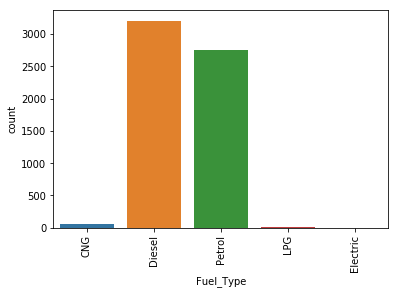

In [132]:
sns.countplot(data.Fuel_Type)
plt.xticks(rotation=90)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

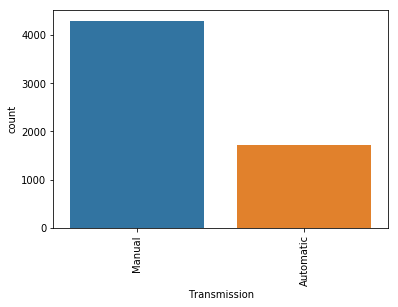

In [133]:
sns.countplot(data.Transmission)
plt.xticks(rotation=90)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

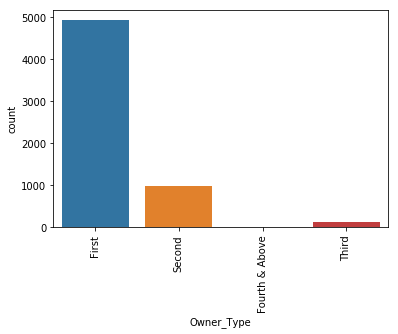

In [134]:
sns.countplot(data.Owner_Type)
plt.xticks(rotation=90)

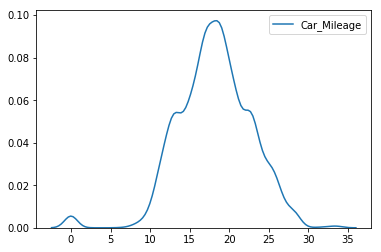

In [153]:
sns.kdeplot(data.Car_Mileage)

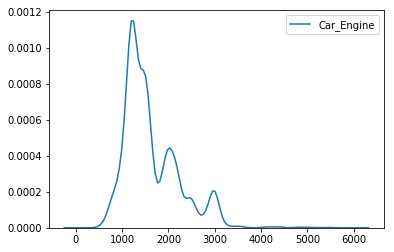

In [156]:
sns.kdeplot(data.Car_Engine)

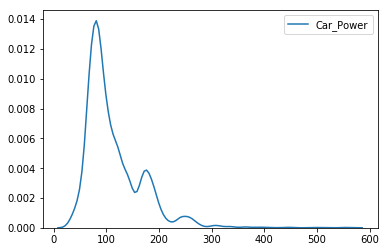

In [157]:
sns.kdeplot(data.Car_Power)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

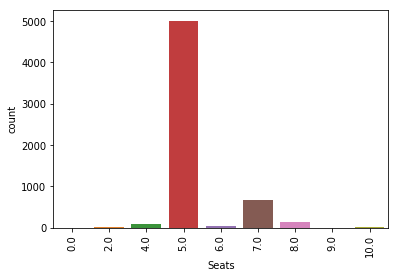

In [159]:
sns.countplot(data.Seats)
plt.xticks(rotation=90)

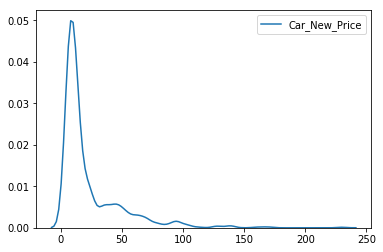

In [208]:
sns.kdeplot(data.Car_New_Price)

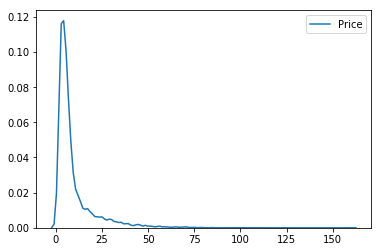

In [183]:
sns.kdeplot(data.Price)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

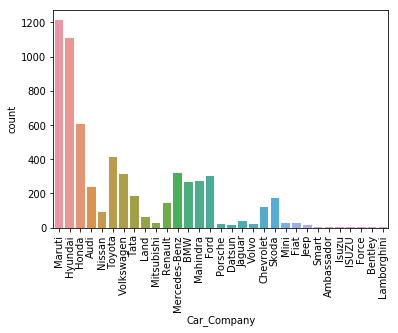

In [210]:
sns.countplot(data.Car_Company)
plt.xticks(rotation=90)

(array([   0,    1,    2, ..., 1873, 1874, 1875]),
 <a list of 1876 Text xticklabel objects>)

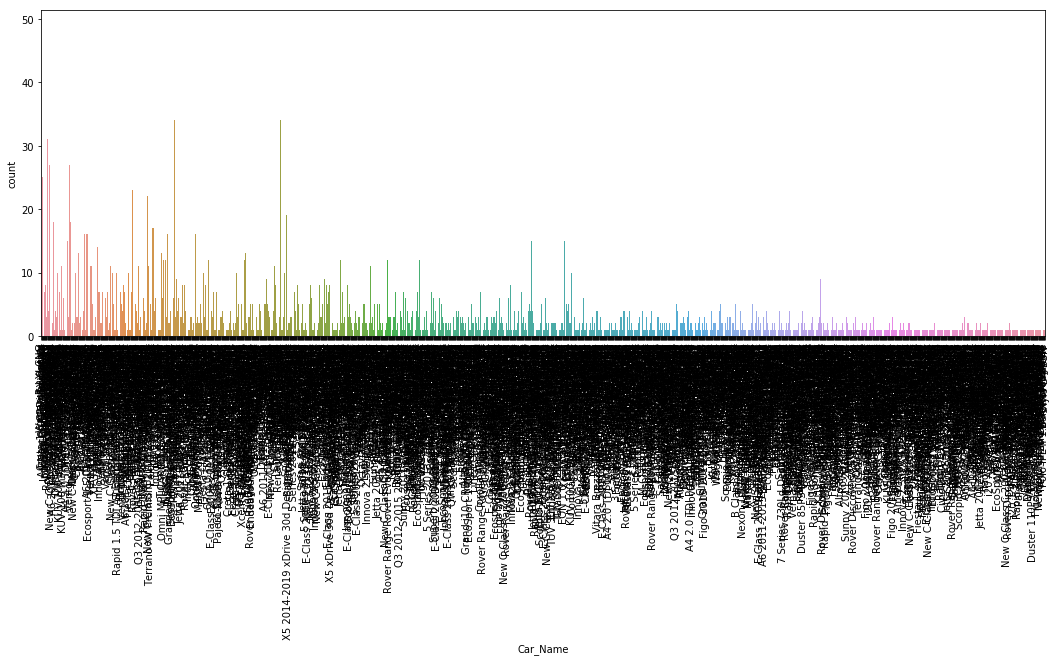

In [222]:
plt.figure(figsize=(18,6))
sns.countplot(data.Car_Name)
plt.xticks(rotation=90)

In [239]:
data['Car_Name'].groupby(data['Car_Name']).count().sort_values(ascending=False)[:20]

Car_Name
XUV500 W8 2WD                 49
Swift VDI                     45
City 1.5 S MT                 34
Swift Dzire VDI               34
Swift VDI BSIV                31
Ritz VDi                      30
i10 Sportz                    30
Fortuner 3.0 Diesel           29
Amaze S i-Dtech               27
Grand i10 Sportz              27
Brio S MT                     25
Ertiga VDI                    25
City 1.5 V MT                 24
Verna 1.6 SX                  23
Wagon R VXI                   23
Wagon R LXI                   22
Alto LXi                      21
Ertiga ZDI                    20
Alto 800 LXI                  20
Superb Elegance 1.8 TSI AT    20
Name: Car_Name, dtype: int64

# Data Cleanup

In [9]:
data.head()

,Engine,Fuel_Type,Kilometers_Driven,Location,Mileage,Name,New_Price,Owner_Type,Power,Price,Seats,Transmission,Year,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,998 CC,CNG,72000,Mumbai,26.6 km/kg,Maruti Wagon R LXI CNG,NaN,First,58.16 bhp,1.75,5.0,Manual,2010,Maruti,Wagon R LXI CNG,26.60,998.0,58.16,NaN
1,1582 CC,Diesel,41000,Pune,19.67 kmpl,Hyundai Creta 1.6 CRDi SX Option,NaN,First,126.2 bhp,12.50,5.0,Manual,2015,Hyundai,Creta 1.6 CRDi SX Option,19.67,1582.0,126.20,NaN
2,1199 CC,Petrol,46000,Chennai,18.2 kmpl,Honda Jazz V,8.61 Lakh,First,88.7 bhp,4.50,5.0,Manual,2011,Honda,Jazz V,18.20,1199.0,88.70,8.61
3,1248 CC,Diesel,87000,Chennai,20.77 kmpl,Maruti Ertiga VDI,NaN,First,88.76 bhp,6.00,7.0,Manual,2012,Maruti,Ertiga VDI,20.77,1248.0,88.76,NaN
4,1968 CC,Diesel,40670,Coimbatore,15.2 kmpl,Audi A4 New 2.0 TDI Multitronic,NaN,Second,140.8 bhp,17.74,5.0,Automatic,2013,Audi,A4 New 2.0 TDI Multitronic,15.20,1968.0,140.80,NaN


In [10]:
(data['Car_New_Price'].isnull().sum()/data['Car_New_Price'].shape[0]) * 100

86.12987729215497

- New_Price data have ~86% of values missing. Hence, dropping the feature for now.

In [12]:
data = data.drop(['Name', 'Mileage', 'Engine', 'Power', 'New_Price'], axis=1)
# y = data['Price']

data.head()

,Fuel_Type,Kilometers_Driven,Location,Owner_Type,Price,Seats,Transmission,Year,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,CNG,72000,Mumbai,First,1.75,5.0,Manual,2010,Maruti,Wagon R LXI CNG,26.60,998.0,58.16,NaN
1,Diesel,41000,Pune,First,12.50,5.0,Manual,2015,Hyundai,Creta 1.6 CRDi SX Option,19.67,1582.0,126.20,NaN
2,Petrol,46000,Chennai,First,4.50,5.0,Manual,2011,Honda,Jazz V,18.20,1199.0,88.70,8.61
3,Diesel,87000,Chennai,First,6.00,7.0,Manual,2012,Maruti,Ertiga VDI,20.77,1248.0,88.76,NaN
4,Diesel,40670,Coimbatore,Second,17.74,5.0,Automatic,2013,Audi,A4 New 2.0 TDI Multitronic,15.20,1968.0,140.80,NaN


In [15]:
data['Location'] = data['Location'].astype('category')
data['Fuel_Type'] = data['Fuel_Type'].astype('category')
data['Transmission'] = data['Transmission'].astype('category')
data['Owner_Type'] = data['Owner_Type'].astype('category')
data['Car_Company'] = data['Car_Company'].astype('category')
data['Car_Name'] = data['Car_Name'].astype('category')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7253 entries, 0 to 1233
Data columns (total 14 columns):
Fuel_Type            7253 non-null category
Kilometers_Driven    7253 non-null int64
Location             7253 non-null category
Owner_Type           7253 non-null category
Price                6019 non-null float64
Seats                7200 non-null float64
Transmission         7253 non-null category
Year                 7253 non-null int64
Car_Company          7253 non-null category
Car_Name             7253 non-null category
Car_Mileage          7251 non-null float64
Car_Engine           7207 non-null float64
Car_Power            7078 non-null float64
Car_New_Price        1006 non-null float64
dtypes: category(6), float64(6), int64(2)
memory usage: 817.9 KB


In [11]:
# location = {v:k for k,v in enumerate(X.Location.cat.categories)}
# fuel_type = {v:k for k,v in enumerate(X.Fuel_Type.cat.categories)}
# transmission = {v:k for k,v in enumerate(X.Transmission.cat.categories)}
# owner_type = {v:k for k,v in enumerate(X.Owner_Type.cat.categories)}
# car_company = {v:k for k,v in enumerate(X.Car_Company.cat.categories)}
# car_name = {v:k for k,v in enumerate(X.Car_Name.cat.categories)}

# print(location, "\n\n", fuel_type, "\n\n", transmission, "\n\n", owner_type, "\n\n", car_company, "\n\n", car_name)

In [17]:
data['Year'] = data['Year'].apply(lambda x: 2019 - x)

## Label Encode Categorical Features

In [19]:
data['Location'] = data['Location'].cat.codes
data['Fuel_Type'] = data['Fuel_Type'].cat.codes
data['Transmission'] = data['Transmission'].cat.codes
data['Owner_Type'] = data['Owner_Type'].cat.codes
data['Car_Company'] = data['Car_Company'].cat.codes
data['Car_Name'] = data['Car_Name'].cat.codes

In [20]:
data.head()

,Fuel_Type,Kilometers_Driven,Location,Owner_Type,Price,Seats,Transmission,Year,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,0,72000,9,0,1.75,5.0,1,9,19,1797,26.60,998.0,58.16,NaN
1,1,41000,10,0,12.50,5.0,1,4,11,498,19.67,1582.0,126.20,NaN
2,4,46000,2,0,4.50,5.0,1,8,10,993,18.20,1199.0,88.70,8.61
3,1,87000,2,0,6.00,7.0,1,7,19,676,20.77,1248.0,88.76,NaN
4,1,40670,3,2,17.74,5.0,0,6,1,105,15.20,1968.0,140.80,NaN


## Fill Missing Values

In [22]:
data.isnull().sum()

Fuel_Type               0
Kilometers_Driven       0
Location                0
Owner_Type              0
Price                1234
Seats                  53
Transmission            0
Year                    0
Car_Company             0
Car_Name                0
Car_Mileage             2
Car_Engine             46
Car_Power             175
Car_New_Price        6247
dtype: int64

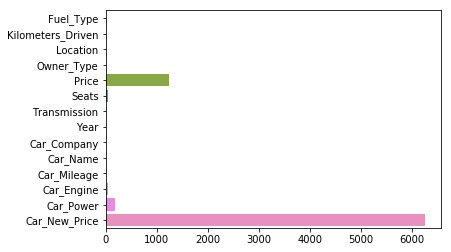

In [21]:
sns.barplot(y=data.columns, x=data.isnull().sum())

In [33]:
data.Seats.mode().loc[0]

5.0

In [51]:
data['Car_Mileage'].fillna((data['Car_Mileage'].mean()), inplace=True)
data['Car_Engine'].fillna((data['Car_Engine'].mean()), inplace=True)
data['Car_Power'].fillna((data['Car_Power'].mean()), inplace=True)
data['Seats'].fillna((data['Seats'].mode().loc[0]), inplace=True)
data['Car_New_Price'].fillna(0, inplace=True)

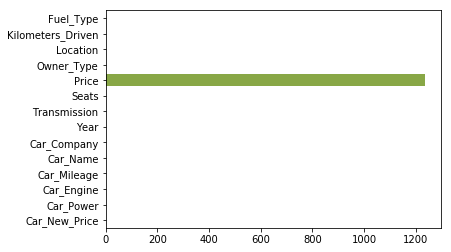

In [52]:
sns.barplot(y=data.columns, x=data.isnull().sum())

In [53]:
data.isnull().sum()

Fuel_Type               0
Kilometers_Driven       0
Location                0
Owner_Type              0
Price                1234
Seats                   0
Transmission            0
Year                    0
Car_Company             0
Car_Name                0
Car_Mileage             0
Car_Engine              0
Car_Power               0
Car_New_Price           0
dtype: int64

In [54]:
data.head()

,Fuel_Type,Kilometers_Driven,Location,Owner_Type,Price,Seats,Transmission,Year,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,0,72000,9,0,1.75,5.0,1,9,19,1797,26.60,998.0,58.16,0.00
1,1,41000,10,0,12.50,5.0,1,4,11,498,19.67,1582.0,126.20,0.00
2,4,46000,2,0,4.50,5.0,1,8,10,993,18.20,1199.0,88.70,8.61
3,1,87000,2,0,6.00,7.0,1,7,19,676,20.77,1248.0,88.76,0.00
4,1,40670,3,2,17.74,5.0,0,6,1,105,15.20,1968.0,140.80,0.00


In [58]:
data_train = data[:training_data_len]
data_test = data[training_data_len:]

In [59]:
X = data_train.drop('Price', axis=1)
y = data_train['Price']

### Fill 'Seats' using ML modelling (Not pursued)

In [19]:
# x_seats_train = []
# x_seats_test = []
# y_seats_train = []
# y_seats_test = []

# def create_train_test(row):
#     if pd.isnull(row['Seats']):
#         x_seats_test.append(row.drop('Seats').values)
#     else:
#         x_seats_train.append(row.drop('Seats').values)
#         y_seats_train.append(row['Seats'])
#     return

# _ = X.apply(create_train_test, axis=1)

In [38]:
# print(f'Training Set: {len(x_seats_train)}, Test Set: {len(x_seats_test)}')

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(
#     np.array(x_seats_train), np.array(y_seats_train), test_size=0.33, random_state=42)

In [39]:
# parameters = {'max_depth': [3, 5, 6, 9, 11],
#               'learning_rate': [1.0, 0.1, 0.01, 0.001],
#               'n_estimators': [50, 75, 100, 150, 200]
#              }
# xgbc = XGBClassifier()
# clf = RandomizedSearchCV(estimator=xgbc, param_distributions=parameters, n_iter=10, verbose=1)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [40]:
# print(f1_score(y_test, y_pred, average='micro'), accuracy_score(y_test, y_pred))
# print(clf.best_estimator_)

In [24]:
# xgbc = XGBClassifier(learning_rate=1.0, max_depth=3, n_estimators=200)
# xgbc.fit(np.array(x_seats_train), np.array(y_seats_train))
# y_seats_test = xgbc.predict(np.array(x_seats_test))

In [42]:
# sorted(list(zip(X.columns.drop('Seats'), xgbc.feature_importances_)), key=lambda x: x[1], reverse=True)

In [41]:
# sns.barplot(y=X.columns.drop('Seats'), x=xgbc.feature_importances_)

In [43]:
# print(y_seats_test.shape, y_seats_test)

In [44]:
# X[X.Seats.isnull()]

In [45]:
# indx = 0
# for i,v in X.Seats.iteritems():
#     if pd.isnull(v):
#         X['Seats'].iloc[i] = y_seats_test[indx]
#         print(f'{i}({X["Seats"].iloc[i]})', end=',')
#         indx += 1

In [46]:
# X[X.Seats.isnull()]

In [579]:
# X['Seats'].fillna(value=5.0, inplace=True)

In [47]:
# X['Seats'].iloc[3800] = 7.0
# X[X.Seats.isnull()]

In [48]:
# X.isnull().sum()

In [49]:
# X.head()

# Save and Load Training/Test Data

In [60]:
# Save the Training data
hdf = pd.HDFStore('Data_Train_2.h5')
hdf.put('X', X, format='table', data_columns=True)
hdf.put('y', y, format='table', data_columns=True)
print(hdf.keys())
hdf.close()

['/X', '/y']


In [61]:
# Save the Test data
hdf = pd.HDFStore('Data_Test_2.h5')
hdf.put('data_test', data_test, format='table', data_columns=True)
print(hdf.keys())
hdf.close()

['/data_test']


In [2]:
# X_train = pd.read_hdf('Data_Train.h5', key='X')
# y_train = pd.read_hdf('Data_Train.h5', key='y')
# X = pd.read_hdf('Data_Train.h5', key='X')
# y = pd.read_hdf('Data_Train.h5', key='y')

In [139]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

## New Features

In [274]:
# new_data = pd.concat([X, y], axis=1)
new_data = data.drop('Car_New_Price', axis=1).reset_index(drop=True)
print(new_data.shape)
new_data.head()

(7253, 13)


,Fuel_Type,Kilometers_Driven,Location,Owner_Type,Price,Seats,Transmission,Year,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power
0,0,72000,9,0,1.75,5.0,1,9,19,1797,26.60,998.0,58.16
1,1,41000,10,0,12.50,5.0,1,4,11,498,19.67,1582.0,126.20
2,4,46000,2,0,4.50,5.0,1,8,10,993,18.20,1199.0,88.70
3,1,87000,2,0,6.00,7.0,1,7,19,676,20.77,1248.0,88.76
4,1,40670,3,2,17.74,5.0,0,6,1,105,15.20,1968.0,140.80


In [214]:
# new_data[new_data.duplicated()]

In [215]:
# new_data[6019:][(new_data['Fuel_Type'] == 4) & (new_data['Kilometers_Driven'] == 52000) \
#                 & (new_data['Year'] == 9) & (new_data['Transmission'] == 1)]

In [155]:
# new_data['Year'] = new_data['Year'].apply(lambda x: 2019 - x)
# new_data.head()

In [275]:
# Feature Engineering from following Columns
agg_func = {
    'Kilometers_Driven': ['sum', 'mean', 'max', 'min', 'std'],
    'Fuel_Type': ['count'],
    'Transmission': ['nunique'],
    'Owner_Type': ['nunique'],
    'Seats': ['nunique'],
    'Car_Company': ['count', 'nunique'],
    'Car_Name': ['count', 'nunique'],
    'Car_Mileage': ['sum', 'mean', 'max', 'min', 'std'],
    'Car_Engine': ['sum', 'mean', 'max', 'min', 'std'],
    'Car_Power': ['sum', 'mean', 'max', 'min', 'std']
}

agg_df = new_data.groupby(['Location', 'Year'], sort=False).agg(agg_func)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.reset_index(inplace=True)

print(agg_df.shape)
agg_df.head()

(199, 30)


,Location,Year,Kilometers_Driven_sum,Kilometers_Driven_mean,Kilometers_Driven_max,Kilometers_Driven_min,Kilometers_Driven_std,Fuel_Type_count,Transmission_nunique,Owner_Type_nunique,...,Car_Engine_sum,Car_Engine_mean,Car_Engine_max,Car_Engine_min,Car_Engine_std,Car_Power_sum,Car_Power_mean,Car_Power_max,Car_Power_min,Car_Power_std
0,9,9,3885339,62666.758065,140000,12000,25225.596930,62,2,3,...,106772.00000,1722.129032,4806.0,796.0,733.130353,7535.490000,121.540161,550.0,46.30,70.838930
1,10,4,4929260,68461.944444,205000,11000,41581.540264,72,2,2,...,113283.57347,1573.382965,2993.0,796.0,582.905183,7338.185214,101.919239,258.0,40.30,44.339813
2,2,8,6001189,89569.985075,248000,24000,44427.758764,67,2,3,...,111899.00000,1670.134328,2993.0,624.0,580.113126,7168.145214,106.987242,245.0,37.48,45.939606
3,2,7,5151695,74662.246377,158000,17000,32369.804507,69,2,3,...,107519.00000,1558.246377,2987.0,814.0,484.923687,6991.690428,101.328847,190.0,55.20,35.468427
4,3,6,3325196,61577.703704,130790,27075,20038.674176,54,2,2,...,84629.00000,1567.203704,4367.0,624.0,642.913515,6071.720428,112.439267,335.3,35.00,58.160924


In [276]:
values = {
    'Kilometers_Driven_std': agg_df['Kilometers_Driven_std'].mean(),
    'Car_Mileage_std': agg_df['Car_Mileage_std'].mean(),
    'Car_Engine_std': agg_df['Car_Engine_std'].mean(),
    'Car_Power_std': agg_df['Car_Power_std'].mean()
}
agg_df.fillna(value=values, inplace=True)

In [277]:
agg_df.isnull().sum()

Location                  0
Year                      0
Kilometers_Driven_sum     0
Kilometers_Driven_mean    0
Kilometers_Driven_max     0
Kilometers_Driven_min     0
Kilometers_Driven_std     0
Fuel_Type_count           0
Transmission_nunique      0
Owner_Type_nunique        0
Seats_nunique             0
Car_Company_count         0
Car_Company_nunique       0
Car_Name_count            0
Car_Name_nunique          0
Car_Mileage_sum           0
Car_Mileage_mean          0
Car_Mileage_max           0
Car_Mileage_min           0
Car_Mileage_std           0
Car_Engine_sum            0
Car_Engine_mean           0
Car_Engine_max            0
Car_Engine_min            0
Car_Engine_std            0
Car_Power_sum             0
Car_Power_mean            0
Car_Power_max             0
Car_Power_min             0
Car_Power_std             0
dtype: int64

In [210]:
# new_data_bckp = new_data.copy()
# new_data = new_data_bckp.copy()

In [278]:
new_data = new_data.merge(new_data.merge(agg_df, on=['Location', 'Year'], sort=False).drop_duplicates())
print(new_data.shape)
new_data.head()

(7253, 41)


,Fuel_Type,Kilometers_Driven,Location,Owner_Type,Price,Seats,Transmission,Year,Car_Company,Car_Name,...,Car_Engine_sum,Car_Engine_mean,Car_Engine_max,Car_Engine_min,Car_Engine_std,Car_Power_sum,Car_Power_mean,Car_Power_max,Car_Power_min,Car_Power_std
0,0,72000,9,0,1.75,5.0,1,9,19,1797,...,106772.00000,1722.129032,4806.0,796.0,733.130353,7535.490000,121.540161,550.0,46.30,70.838930
1,1,41000,10,0,12.50,5.0,1,4,11,498,...,113283.57347,1573.382965,2993.0,796.0,582.905183,7338.185214,101.919239,258.0,40.30,44.339813
2,4,46000,2,0,4.50,5.0,1,8,10,993,...,111899.00000,1670.134328,2993.0,624.0,580.113126,7168.145214,106.987242,245.0,37.48,45.939606
3,1,87000,2,0,6.00,7.0,1,7,19,676,...,107519.00000,1558.246377,2987.0,814.0,484.923687,6991.690428,101.328847,190.0,55.20,35.468427
4,1,40670,3,2,17.74,5.0,0,6,1,105,...,84629.00000,1567.203704,4367.0,624.0,642.913515,6071.720428,112.439267,335.3,35.00,58.160924


In [224]:
# new_data[training_data_len-2:training_data_len+5]#['Price'].isnull().sum()
# new_data[6019:][(new_data['Fuel_Type'] == 4) & (new_data['Kilometers_Driven'] == 52000) \
#                 & (new_data['Year'] == 9) & (new_data['Transmission'] == 1)]
# new_data[6019:]['Price'].isnull().sum()

In [258]:
# --> Feature Engineering from 'Car_New_Price'
# agg_func = {
#     'Car_New_Price': ['sum', 'mean', 'max', 'min', 'std']
# }

# agg_df = new_data.groupby(['Location', 'Year', 'Car_Company', 'Car_Name'], sort=False).agg(agg_func)
# agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
# agg_df.reset_index(inplace=True)

# print(agg_df.shape)
# agg_df.head()

In [226]:
# values = {
#     'Car_New_Price_std': agg_df['Car_New_Price_std'].mean()
# }
# agg_df.fillna(value=values, inplace=True)

In [259]:
# agg_df.isnull().sum()

In [260]:
# new_data = new_data.merge(new_data.merge(agg_df, on=['Location', 'Year', 'Car_Company', 'Car_Name'],\
#                                          sort=False).drop_duplicates())
# print(new_data.shape)
# new_data.head(10)

In [279]:
test_data = new_data[training_data_len:]
test_data.shape

(1234, 41)

In [280]:
X = new_data[:training_data_len].drop('Price', axis=1)
y = new_data[:training_data_len]['Price']

In [34]:
# sns.heatmap(new_data.corr())

In [74]:
# --> New Features with Sales Count of Grouped Columns
# new_data = new_data.merge(new_data[['Location', 'Price']].groupby('Location').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_loc'}), on=['Location'])

# new_data = new_data.merge(new_data[['Year', 'Price']].groupby('Year').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_year'}), on=['Year'])

# new_data = new_data.merge(new_data[['Kilometers_Driven', 'Price']].groupby('Kilometers_Driven').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_driven'}), on=['Kilometers_Driven'])

# new_data = new_data.merge(new_data[['Car_Company', 'Price']].groupby('Car_Company').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_company'}), on=['Car_Company'])

# new_data = new_data.merge(new_data[['Car_Name', 'Price']].groupby('Car_Name').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_name'}), on=['Car_Name'])

# new_data = new_data.merge(new_data[['Car_Mileage', 'Price']].groupby('Car_Mileage').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_mileage'}), on=['Car_Mileage'])

# new_data = new_data.merge(new_data[['Car_Power', 'Price']].groupby('Car_Power').count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_power'}), on=['Car_Power'])

# new_data.head()

In [73]:
# --> New Features with Sales Count of Grouped Columns (two and three cols)
# new_data = new_data.merge(new_data[['Location', 'Year', 'Price']].groupby(['Location', 'Year']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_loc_year'}), on=['Location', 'Year'])

# new_data = new_data.merge(new_data[['Location', 'Car_Name', 'Price']].groupby(['Location', 'Car_Name']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_loc_name'}), on=['Location', 'Car_Name'])

# new_data = new_data.merge(new_data[['Location', 'Car_Company', 'Price']].groupby(['Location', 'Car_Company']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_loc_company'}), on=['Location', 'Car_Company'])

# new_data = new_data.merge(new_data[['Location', 'Kilometers_Driven', 'Price']].groupby(['Location', 'Kilometers_Driven']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_loc_driven'}), on=['Location', 'Kilometers_Driven'])

# new_data = new_data.merge(new_data[['Car_Name', 'Car_Company', 'Price']].groupby(['Car_Name', 'Car_Company']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_name_company'}), on=['Car_Name', 'Car_Company'])

# new_data = new_data.merge(new_data[['Year', 'Car_Name', 'Price']].groupby(['Year', 'Car_Name']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_year_name'}), on=['Year', 'Car_Name'])

# new_data = new_data.merge(new_data[['Year', 'Car_Company', 'Price']].groupby(['Year', 'Car_Company']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_year_company'}), on=['Year', 'Car_Company'])

# new_data = new_data.merge(new_data[['Location', 'Year', 'Car_Company', 'Price']].groupby(['Location', 'Year', 'Car_Company']).count()\
#                           .reset_index().rename(columns={'Price': 'count_grp_loc_year_company'}), on=['Location', 'Year', 'Car_Company'])

# new_data.head()

In [72]:
# --> New Features with Mean of Grouped Columns
# new_data = new_data.merge(new_data[['Location', 'Price']].groupby('Location').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_loc'}), on=['Location'])

# new_data = new_data.merge(new_data[['Year', 'Price']].groupby('Year').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_year'}), on=['Year'])

# new_data = new_data.merge(new_data[['Kilometers_Driven', 'Price']].groupby('Kilometers_Driven').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_driven'}), on=['Kilometers_Driven'])

# new_data = new_data.merge(new_data[['Car_Company', 'Price']].groupby('Car_Company').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_company'}), on=['Car_Company'])

# new_data = new_data.merge(new_data[['Car_Name', 'Price']].groupby('Car_Name').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_name'}), on=['Car_Name'])

# new_data = new_data.merge(new_data[['Car_Mileage', 'Price']].groupby('Car_Mileage').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_mileage'}), on=['Car_Mileage'])

# new_data = new_data.merge(new_data[['Car_Power', 'Price']].groupby('Car_Power').mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_power'}), on=['Car_Power'])

# new_data.head()

In [65]:
# --> New Features with Mean of Grouped Columns (two and three cols)
# new_data = new_data.merge(new_data[['Location', 'Year', 'Price']].groupby(['Location', 'Year']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_loc_year'}), on=['Location', 'Year'])

# new_data = new_data.merge(new_data[['Location', 'Car_Name', 'Price']].groupby(['Location', 'Car_Name']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_loc_name'}), on=['Location', 'Car_Name'])

# new_data = new_data.merge(new_data[['Location', 'Car_Company', 'Price']].groupby(['Location', 'Car_Company']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_loc_company'}), on=['Location', 'Car_Company'])

# new_data = new_data.merge(new_data[['Location', 'Kilometers_Driven', 'Price']].groupby(['Location', 'Kilometers_Driven']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_loc_driven'}), on=['Location', 'Kilometers_Driven'])

# new_data = new_data.merge(new_data[['Car_Name', 'Car_Company', 'Price']].groupby(['Car_Name', 'Car_Company']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_name_company'}), on=['Car_Name', 'Car_Company'])

# new_data = new_data.merge(new_data[['Year', 'Car_Name', 'Price']].groupby(['Year', 'Car_Name']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_year_name'}), on=['Year', 'Car_Name'])

# new_data = new_data.merge(new_data[['Year', 'Car_Company', 'Price']].groupby(['Year', 'Car_Company']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_year_company'}), on=['Year', 'Car_Company'])

# new_data = new_data.merge(new_data[['Location', 'Year', 'Car_Company', 'Price']].groupby(['Location', 'Year', 'Car_Company']).mean()\
#                           .reset_index().rename(columns={'Price': 'mean_grp_loc_year_company'}), on=['Location', 'Year', 'Car_Company'])

# new_data.head()

In [71]:
# --> New Features with Standard Deviation of Grouped Columns
# new_data = new_data.merge(new_data[['Location', 'Price']].groupby('Location').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_loc'}), on=['Location'])

# new_data = new_data.merge(new_data[['Year', 'Price']].groupby('Year').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_year'}), on=['Year'])

# new_data = new_data.merge(new_data[['Kilometers_Driven', 'Price']].groupby('Kilometers_Driven').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_driven'}), on=['Kilometers_Driven'])

# new_data = new_data.merge(new_data[['Car_Company', 'Price']].groupby('Car_Company').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_company'}), on=['Car_Company'])

# new_data = new_data.merge(new_data[['Car_Name', 'Price']].groupby('Car_Name').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_name'}), on=['Car_Name'])

# new_data = new_data.merge(new_data[['Car_Mileage', 'Price']].groupby('Car_Mileage').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_mileage'}), on=['Car_Mileage'])

# new_data = new_data.merge(new_data[['Car_Power', 'Price']].groupby('Car_Power').std()\
#                           .reset_index().rename(columns={'Price': 'std_grp_power'}), on=['Car_Power'])

# new_data.head()

In [70]:
# sns.heatmap(new_data.corr())
# new_data.corr()

In [68]:
# new_data['std_grp_driven'].fillna(new_data['std_grp_driven'].mean(), inplace=True)
# new_data['std_grp_company'].fillna(new_data['std_grp_company'].median(), inplace=True)
# new_data['std_grp_name'].fillna(new_data['std_grp_name'].median(), inplace=True)
# new_data['std_grp_mileage'].fillna(new_data['std_grp_mileage'].median(), inplace=True)
# new_data['std_grp_power'].fillna(new_data['std_grp_power'].median(), inplace=True)

In [69]:
# new_data.isnull().sum()

In [63]:
# grpd_year_mean = new_data.groupby('Year').mean()['Price']
# mean_grp_year.head()

In [64]:
# mean_grp_year.loc[1999]
# new_data.iloc[6018]
# a = new_data.groupby('Year').mean()['Price'].reset_index()
# a.columns=['Year', 'mean_grp_year']
# new_data.merge(a, on=['Year'])
# new_data.groupby('Year', as_index=False).mean()['Price']

In [91]:
# new_data[['Year', 'Price']].groupby('Year', as_index=True).count().reset_index().rename(columns={'Price': 'XXX'})

In [67]:
# X = new_data.drop(['Price'], axis=1)

In [419]:
# --> Recursive Feature Elimination
# model = XGBRegressor()
# rfe = RFE(model, 15)
# mod_fit = rfe.fit(X, y)

# print(f"Num Features: {mod_fit.n_features_}")
# print(f"Selected Features: {mod_fit.support_}")
# print(f"Feature Ranking: {mod_fit.ranking_}")

# best_feats = []
# for col,support in zip(X.columns, mod_fit.support_):
#     if support:
#         best_feats.append(col)
# print(best_feats)

In [420]:
# X = new_data[best_feats]
# print(X.shape)
# X.head()

In [66]:
# pca = PCA(n_components=10)
# pca_fit = pca.fit(X)
# pca_X = pca.fit_transform(X)
# print(f"Explained Variance: {pca_fit.explained_variance_ratio_}")

In [65]:
# pca_Cols = [f'PC_{i}' for i in range(1,11)]
# pca_X = pd.DataFrame(pca_X, columns=pca_Cols)
# pca_X.head()

In [64]:
# pca_X.isnull().sum()

In [443]:
# X = pca_X.copy()

In [310]:
# Save the Training data
hdf = pd.HDFStore('Data_Train_3.h5')
hdf.put('X', X, format='table', data_columns=True)
hdf.put('y', y, format='table', data_columns=True)
print(hdf.keys())
hdf.close()

# Save the Test data
hdf = pd.HDFStore('Data_Test_3.h5')
hdf.put('test_data', test_data, format='table', data_columns=True)
print(hdf.keys())
hdf.close()

['/X', '/y']
['/test_data']


In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [282]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Lasso Regression Model

In [283]:
parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False],
             'alpha': [1.0, 0.1, 0.01, 0.001, 10.0, 100.0]}

lass = Lasso()
reg_lass = RandomizedSearchCV(estimator=lass, param_distributions=parameters, n_iter=30, verbose=1)
reg_lass.fit(X_train, y_train)
y_pred_lass = reg_lass.predict(X_test)

print(reg_lass.best_estimator_)

score_lass = np.log(np.sqrt(np.mean((y_pred_lass - y_test)**2)))
print(score_lass)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.7s finished


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
1.969849892836639


In [284]:
sorted(list(zip(X.columns, reg_lass.best_estimator_.coef_)), key=lambda x: x[1], reverse=True)

[('Car_Power', 6.443695339719842),
 ('Car_Power_sum', 1.2044442906598727),
 ('Car_Engine', 1.1649391509289075),
 ('Kilometers_Driven_mean', 0.6333681051789625),
 ('Car_Engine_min', 0.3961736743130936),
 ('Car_Mileage_std', 0.24632054659198074),
 ('Kilometers_Driven_min', 0.21413376832024336),
 ('Car_Power_std', 0.21144728018940384),
 ('Car_Name', 0.16450554106507417),
 ('Car_Mileage_min', 0.10543673834571425),
 ('Seats_nunique', 0.04158272651330558),
 ('Car_Engine_std', 0.008540523883527653),
 ('Kilometers_Driven_std', 0.0),
 ('Owner_Type_nunique', -0.0),
 ('Car_Company_nunique', -0.0),
 ('Car_Name_count', -0.0),
 ('Car_Name_nunique', 0.0),
 ('Car_Mileage_sum', -0.0),
 ('Car_Engine_sum', 0.0),
 ('Car_Power_max', 0.0),
 ('Car_Company_count', -0.0031134892891461516),
 ('Owner_Type', -0.014781691934859443),
 ('Car_Engine_mean', -0.02670975583589708),
 ('Car_Engine_max', -0.04967079707931111),
 ('Car_Company', -0.08611767700950074),
 ('Kilometers_Driven_max', -0.24758150740050416),
 ('Fuel

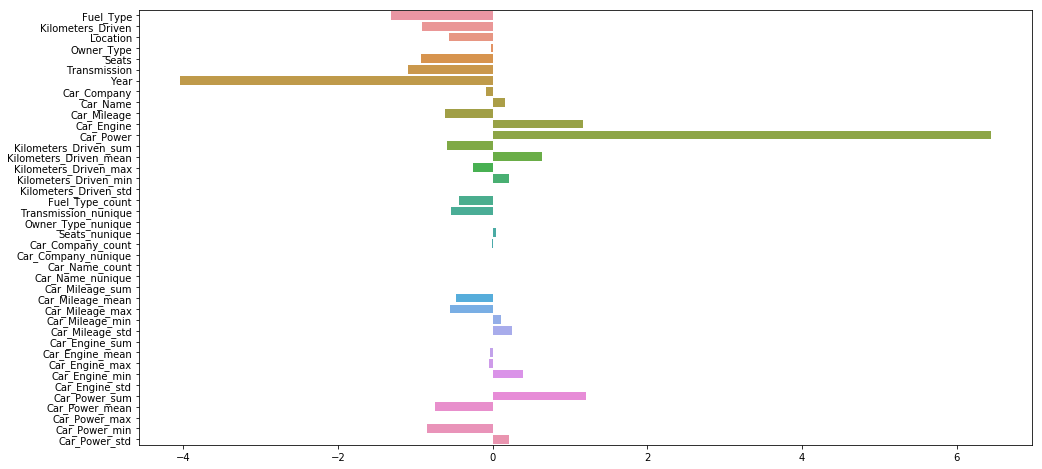

In [285]:
plt.figure(figsize=(16,8))
sns.barplot(y=X.columns, x=reg_lass.best_estimator_.coef_)

## Ridge Regression Model

In [286]:
parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False],
             'alpha': [1.0, 0.1, 0.01, 0.001, 10.0]}

rid = Ridge()
reg_rid = RandomizedSearchCV(estimator=rid, param_distributions=parameters, n_iter=30, verbose=1)
reg_rid.fit(X_train, y_train)
y_pred_rid = reg_rid.predict(X_test)

print(reg_rid.best_estimator_)

score_rid = np.log(np.sqrt(np.mean((y_pred_rid - y_test)**2)))
print(score_rid)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.7s finished


Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)
1.9703510432490488


In [287]:
sorted(list(zip(X.columns, reg_rid.best_estimator_.coef_)), key=lambda x: x[1], reverse=True)

[('Car_Power', 6.382151163244169),
 ('Car_Mileage_sum', 3.434635171849381),
 ('Car_Power_sum', 2.8005629076029703),
 ('Car_Engine_sum', 1.914935475330771),
 ('Car_Engine', 1.2486135109597012),
 ('Kilometers_Driven_std', 0.8207608433766265),
 ('Car_Name_nunique', 0.5598759863557913),
 ('Kilometers_Driven_mean', 0.5146125051364283),
 ('Car_Engine_min', 0.5059977372398609),
 ('Car_Name', 0.1861186685546948),
 ('Kilometers_Driven_min', 0.17557335681960445),
 ('Car_Engine_std', 0.17469261778487968),
 ('Seats_nunique', 0.14876261630430326),
 ('Car_Mileage_std', 0.1460070826312321),
 ('Car_Power_std', 0.13481085766241852),
 ('Car_Mileage_min', 0.10791950053745972),
 ('Owner_Type_nunique', 0.05796606954051816),
 ('Car_Company_nunique', 0.04701563971274512),
 ('Car_Power_max', -0.019100533709592745),
 ('Owner_Type', -0.033822005612462853),
 ('Car_Company', -0.11570452774489084),
 ('Car_Engine_max', -0.15019039863204517),
 ('Car_Engine_mean', -0.20685827378100138),
 ('Transmission_nunique', -0.4

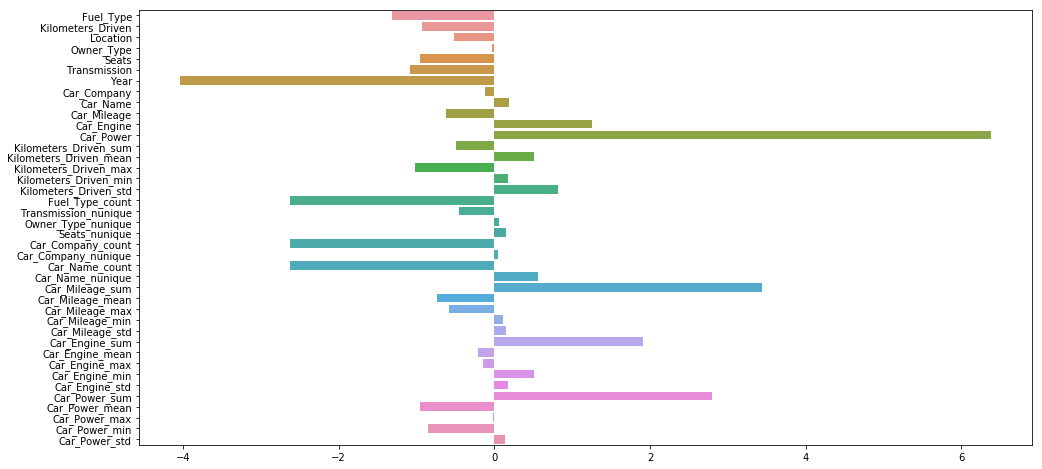

In [288]:
plt.figure(figsize=(16,8))
sns.barplot(y=X.columns, x=reg_rid.best_estimator_.coef_)

## ElasticNet Regression Model

In [289]:
parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False],
             'alpha': [1.0, 0.1, 0.01, 0.001, 10.0], 'l1_ratio': [0.5, 0.1, 0.8, 0.2]}

enet = ElasticNet()
reg_enet = RandomizedSearchCV(estimator=enet, param_distributions=parameters, n_iter=30, verbose=1)
reg_enet.fit(X_train, y_train)
y_pred_enet = reg_enet.predict(X_test)

print(reg_enet.best_estimator_)

score_enet = np.log(np.sqrt(np.mean((y_pred_enet - y_test)**2)))
print(score_enet)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   17.6s finished


ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
1.9701982809765082


In [290]:
sorted(list(zip(X.columns, reg_enet.best_estimator_.coef_)), key=lambda x: x[1], reverse=True)

[('Car_Power', 6.385612760859393),
 ('Car_Mileage_sum', 3.6769389238530303),
 ('Car_Power_sum', 2.61396603002921),
 ('Car_Engine_sum', 2.33982862089717),
 ('Car_Engine', 1.2463583213939657),
 ('Kilometers_Driven_std', 0.806065507666399),
 ('Car_Name_nunique', 0.6909815368755058),
 ('Kilometers_Driven_mean', 0.5139731140592989),
 ('Car_Engine_min', 0.508816199197528),
 ('Car_Name', 0.18578624825889006),
 ('Kilometers_Driven_min', 0.172691961366057),
 ('Car_Engine_std', 0.1712130149968212),
 ('Car_Power_std', 0.1450589792179559),
 ('Seats_nunique', 0.140106377313398),
 ('Car_Mileage_std', 0.13762069723054815),
 ('Car_Mileage_min', 0.1007088643768114),
 ('Owner_Type_nunique', 0.06287196364723131),
 ('Car_Company_nunique', 0.05136200298211908),
 ('Car_Power_max', -0.03270374202835519),
 ('Owner_Type', -0.03445917811366639),
 ('Car_Company', -0.11568232059459144),
 ('Car_Engine_max', -0.14722065051466265),
 ('Car_Engine_mean', -0.22849157129641914),
 ('Transmission_nunique', -0.446660083359

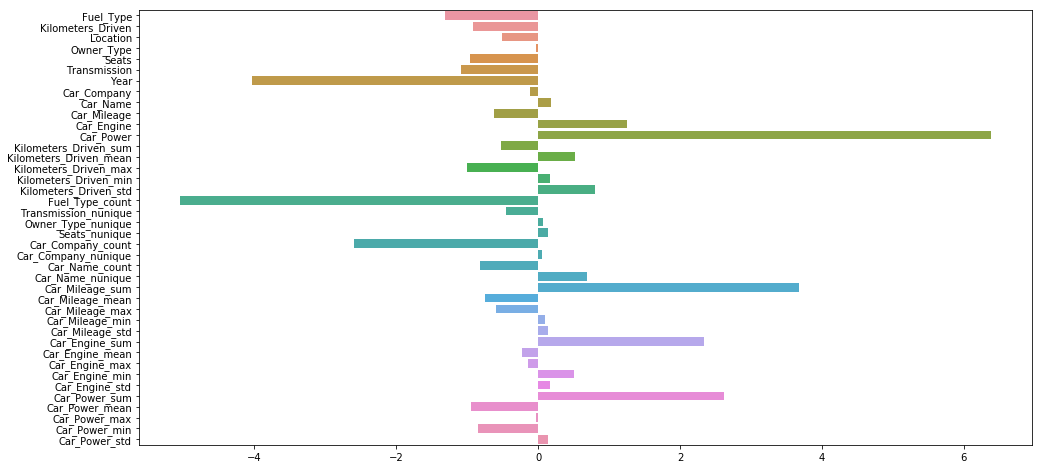

In [291]:
plt.figure(figsize=(16,8))
sns.barplot(y=X.columns, x=reg_enet.best_estimator_.coef_)

## XGBoost Regression Model

In [292]:
parameters = {'max_depth': [3, 5, 6, 9, 11],
              'learning_rate': [1.0, 0.1, 0.01, 0.001],
              'n_estimators': [50, 75, 100, 150, 200, 225],
              'reg_alpha': [1, 0, 0.1, 0.01, 1e-4],
              'reg_lambda': [1, 0, 0.1, 0.01, 1e-4],
              'subsample': [0.3, 0.5, 0.75, 0.9],
              'min_child_weight=1': [2, 4, 6, 8, 10],
              'colsample_bytree': [0.3, 0.6, 0.9, 1.0],
              'colsample_bylevel': [0.3, 0.6, 0.9, 1.0]
             }
xgbr = XGBRegressor()
reg_xgbr = RandomizedSearchCV(estimator=xgbr, param_distributions=parameters, n_iter=10, verbose=1)
reg_xgbr.fit(X_train, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test)

print(reg_xgbr.best_estimator_)

score_xgbr = np.log(np.sqrt(np.mean((y_pred_xgbr - y_test)**2)))
print(score_xgbr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   44.5s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, min_child_weight=1=6, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.0001, reg_lambda=0.01,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.5)
1.3821771906454392


In [293]:
sorted(list(zip(X.columns, reg_xgbr.best_estimator_.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Car_Power', 0.091393754),
 ('Car_Name', 0.073006205),
 ('Car_Mileage', 0.07159177),
 ('Kilometers_Driven', 0.07061256),
 ('Car_Engine', 0.06462844),
 ('Car_Company', 0.04221521),
 ('Kilometers_Driven_mean', 0.03449026),
 ('Kilometers_Driven_sum', 0.033511043),
 ('Seats', 0.033075836),
 ('Kilometers_Driven_max', 0.031987812),
 ('Year', 0.0312262),
 ('Location', 0.031008596),
 ('Kilometers_Driven_std', 0.026982918),
 ('Fuel_Type_count', 0.022630835),
 ('Car_Mileage_mean', 0.022304429),
 ('Transmission', 0.019366771),
 ('Kilometers_Driven_min', 0.019040365),
 ('Car_Engine_std', 0.018605158),
 ('Car_Power_mean', 0.017952345),
 ('Car_Mileage_std', 0.016755521),
 ('Car_Engine_mean', 0.015885105),
 ('Car_Power_max', 0.015885105),
 ('Owner_Type', 0.015449896),
 ('Car_Mileage_max', 0.01512349),
 ('Car_Company_nunique', 0.0150146885),
 ('Car_Company_count', 0.013817865),
 ('Car_Engine_sum', 0.013709064),
 ('Car_Power_std', 0.012621042),
 ('Car_Name_count', 0.012403438),
 ('Car_Mileage_sum', 0

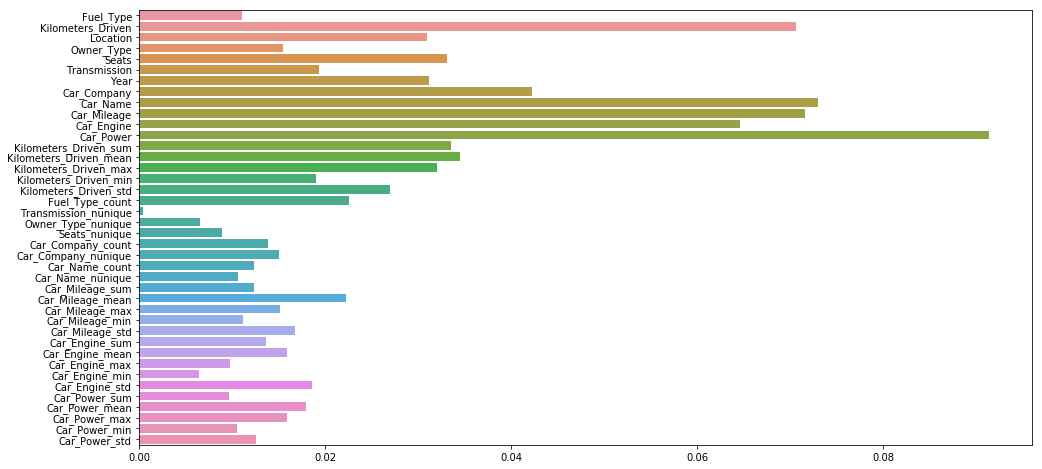

In [294]:
plt.figure(figsize=(16,8))
sns.barplot(y=X.columns, x=reg_xgbr.best_estimator_.feature_importances_)

## Linear Regression Model

In [295]:
parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

lr = LinearRegression()
reg_lr = RandomizedSearchCV(estimator=lr, param_distributions=parameters, n_iter=30, verbose=1)
reg_lr.fit(X_train, y_train)
y_pred_lr = reg_lr.predict(X_test)

print(reg_lr.best_estimator_)

score_lr = np.log(np.sqrt(np.mean((y_pred_lr - y_test)**2)))
print(score_lr)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
1.9679540185191908


In [296]:
sorted(list(zip(X.columns, reg_lr.best_estimator_.coef_)), key=lambda x: x[1], reverse=True)

[('Car_Mileage_sum', 7.227782468263011),
 ('Car_Power', 6.416440378869131),
 ('Car_Engine_sum', 4.021498311613697),
 ('Car_Power_sum', 3.560739811742137),
 ('Car_Engine', 1.2398473109129544),
 ('Kilometers_Driven_std', 0.9055177343782553),
 ('Car_Name_nunique', 0.685178737897509),
 ('Car_Engine_min', 0.5283814839957799),
 ('Kilometers_Driven_mean', 0.4059791715691345),
 ('Car_Engine_std', 0.22207723018279815),
 ('Seats_nunique', 0.19394352509556279),
 ('Car_Name', 0.18894920921580208),
 ('Car_Power_std', 0.1385165095864064),
 ('Kilometers_Driven_min', 0.12223936227524813),
 ('Owner_Type_nunique', 0.10682925030717426),
 ('Car_Company_nunique', 0.07398481165022952),
 ('Car_Mileage_min', 0.04369841283807483),
 ('Car_Mileage_std', 0.0061870293344868455),
 ('Owner_Type', -0.03737353609872832),
 ('Car_Power_max', -0.1158008767388352),
 ('Car_Company', -0.11586798043770909),
 ('Car_Engine_max', -0.13129832715975784),
 ('Car_Engine_mean', -0.32742454784149155),
 ('Transmission_nunique', -0.395

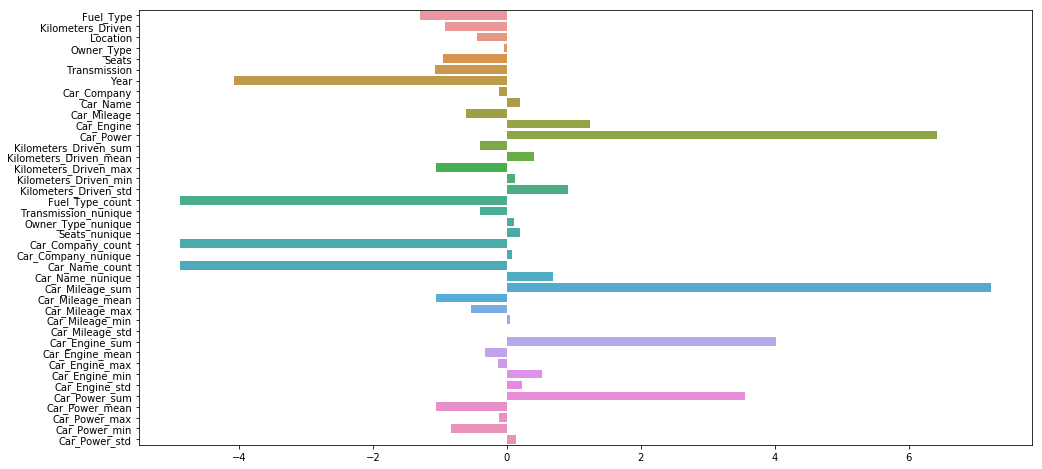

In [297]:
plt.figure(figsize=(16,8))
sns.barplot(y=X.columns, x=reg_lr.best_estimator_.coef_)

## Random Forest Regressor Model

In [298]:
param_dist = {"n_estimators": sp_randint(50,225),
              "max_depth": sp_randint(5,15),
              "min_samples_split": sp_randint(50,190),
              "min_samples_leaf": sp_randint(15,35)
             }

randf = RandomForestRegressor()
reg_rfr = RandomizedSearchCV(estimator=randf, param_distributions=param_dist, n_iter=10, verbose=1)
reg_rfr.fit(X_train, y_train)
y_pred_rfr = reg_rfr.predict(X_test)

print(reg_rfr.best_estimator_)

score_rfr = np.log(np.sqrt(np.mean((y_pred_rfr - y_test)**2)))
print(score_rfr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=28, min_samples_split=57,
           min_weight_fraction_leaf=0.0, n_estimators=124, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
1.47310752450033


In [299]:
sorted(list(zip(X.columns, reg_rfr.best_estimator_.feature_importances_)), key=lambda x: x[1], reverse=True)

[('Car_Power', 0.7536120317577881),
 ('Year', 0.15189383667545892),
 ('Car_Engine', 0.03345658988382066),
 ('Kilometers_Driven', 0.025081053610081654),
 ('Car_Company', 0.009396350296303667),
 ('Transmission', 0.009059347344453805),
 ('Car_Mileage_mean', 0.002629160549456689),
 ('Car_Name', 0.0023607942374954736),
 ('Car_Mileage_max', 0.0021072296612785323),
 ('Car_Mileage', 0.0017742629128825451),
 ('Kilometers_Driven_mean', 0.0013264236859375194),
 ('Kilometers_Driven_std', 0.00091992676324567),
 ('Car_Power_min', 0.000700793449122027),
 ('Car_Mileage_std', 0.0005702168693008377),
 ('Location', 0.00053689522645178),
 ('Car_Power_sum', 0.0005271630417858753),
 ('Car_Name_nunique', 0.0004913825791873342),
 ('Kilometers_Driven_min', 0.00038039421342264223),
 ('Car_Engine_max', 0.00036922372598543736),
 ('Seats', 0.0003065959890233194),
 ('Car_Company_nunique', 0.0002968488296238673),
 ('Car_Power_std', 0.0002892191401289072),
 ('Car_Engine_std', 0.0002583284212267939),
 ('Kilometers_Dri

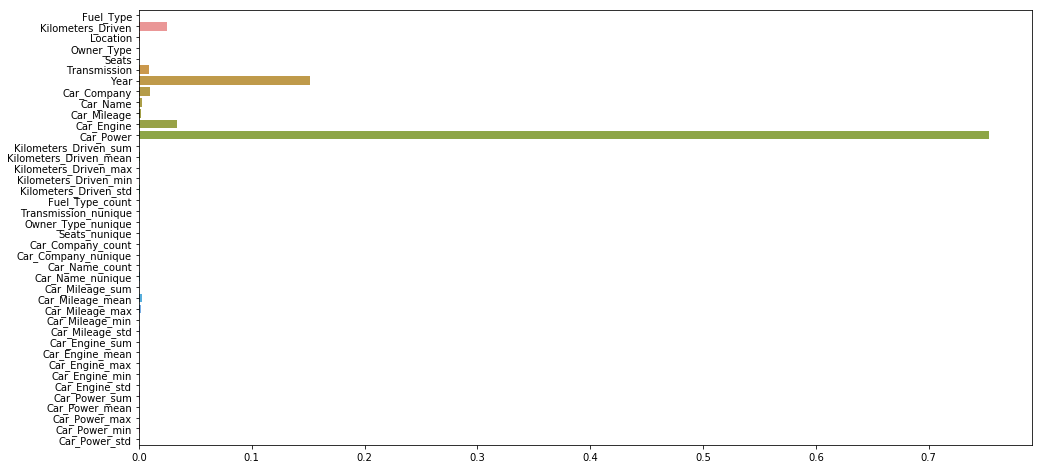

In [300]:
plt.figure(figsize=(16,8))
sns.barplot(y=X.columns, x=reg_rfr.best_estimator_.feature_importances_)

## Neural Network Model

In [309]:
model_nn = Sequential()
model_nn.add(Dense(1048, input_shape=(X_train.shape[1],), activation='relu'))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(512, activation='relu'))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(1, activation='relu'))

model_nn.compile(optimizer='adam', loss='mean_squared_error')
model_nn.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.3, verbose=0)

# score = model_nn.evaluate(nn_final_data_test, y_test, batch_size=32)
y_pred_nn = model_nn.predict(X_test).ravel()

# print(reg.best_estimator_)

score_nn = np.log(np.sqrt(np.mean((y_pred_nn - y_test)**2)))
print(score_nn)

1.7787665547758624


## Combining the Predictions

In [173]:
y_pred_xgbr.shape[0]*0.7

1390.8999999999999

In [302]:
def combo_regressor(X_train, y_train):
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

    lr = LinearRegression()
    reg = RandomizedSearchCV(estimator=lr, param_distributions=parameters, n_iter=10, verbose=1)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_train)

    return reg.best_estimator_

In [303]:
final_model = combo_regressor(np.vstack((y_pred_lass[:1390], y_pred_rid[:1390], y_pred_enet[:1390], \
                                         y_pred_xgbr[:1390], y_pred_lr[:1390], \
                                         y_pred_rfr[:1390], y_pred_nn[:1390])).T,
                              y_test[:1390])

y_pred = final_model.predict(np.vstack((y_pred_lass[1391:], y_pred_rid[1391:], y_pred_enet[1391:], \
                                        y_pred_xgbr[1391:], y_pred_lr[1391:], y_pred_rfr[1391:], y_pred_nn[1391:])).T)
score = np.log(np.sqrt(np.mean((y_pred - y_test[1391:])**2)))
print(f'Final Prediction Score: {score}')

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished


Final Prediction Score: 1.2561842017125697


In [204]:
# Predicting the Final Output based on the Means of all the Base Models
# y_pred = (y_pred_xgbr + y_pred_lr + y_pred_rfr + y_pred_nn)/4
# score = np.log(np.sqrt(np.mean((y_pred - y_test)**2)))

In [304]:
print(f'Lasso Score: {score_lass}, \nRidge Score: {score_rid}, \nE-Net: {score_enet}, \n\
XGBR Score: {score_xgbr}, \nLR Score: {score_lr}, \nRFR Score: {score_rfr}, \nNN Score: {score_nn}')
print(f'Final Prediction Score: {score}')

Lasso Score: 1.969849892836639, 
Ridge Score: 1.9703510432490488, 
E-Net: 1.9701982809765082, 
XGBR Score: 1.3821771906454392, 
LR Score: 1.9679540185191908, 
RFR Score: 1.47310752450033, 
NN Score: 1.6450117139843563
Final Prediction Score: 1.2561842017125697


# Test Data Manipulation

In [179]:
test_data = pd.read_excel('Data_Test.xlsx')
test_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN
1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN
2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh
3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0,NaN
4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN


In [180]:
test_data['Power'] = test_data['Power'].apply(lambda x: np.nan if (type(x) is not float) and ('null' in x) else x)
test_data['Car_Company'] = test_data['Name'].progress_apply(lambda x: x.split()[0])
test_data['Car_Name'] = test_data['Name'].progress_apply(lambda x: ' '.join(x.split()[1:]))
test_data['Car_Mileage'] = test_data['Mileage'].progress_apply(lambda x: x.split()[0] if x is not np.nan else x).astype(np.float64)
test_data['Car_Engine'] = test_data['Engine'].progress_apply(lambda x: x.split()[0] if x is not np.nan else x).astype(np.float64)
test_data['Car_Power'] = test_data['Power'].progress_apply(lambda x: x.split()[0] if x is not np.nan else x).astype(np.float64)

100%|██████████████████████████████████████████████████████████████████████████| 1234/1234 [00:00<00:00, 308669.56it/s]


In [181]:
test_data['Car_New_Price'] = test_data['New_Price'].apply(get_price).astype(np.float)

In [182]:
test_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN,Maruti,Alto K10 LXI CNG,32.26,998.0,58.20,NaN
1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN,Maruti,Alto 800 2016-2019 LXI,24.70,796.0,47.30,NaN
2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh,Toyota,Innova Crysta Touring Sport 2.4 MT,13.68,2393.0,147.80,25.27
3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,NaN,5.0,NaN,Toyota,Etios Liva GD,23.59,1364.0,NaN,NaN
4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN,Hyundai,i20 Magna,18.50,1197.0,82.85,NaN


In [183]:
indx = 31
for i in test_data['Car_Company'].unique():
    if i not in car_company:
        car_company[i] = indx
        indx += 1

In [184]:
indx = 1876

for i in test_data['Car_Name'].unique():
    if i not in car_name:
        car_name[i] = indx
        indx += 1

In [185]:
test_data['Location'] = test_data['Location'].progress_apply(lambda x: location[x])
test_data['Fuel_Type'] = test_data['Fuel_Type'].progress_apply(lambda x: fuel_type[x])
test_data['Transmission'] = test_data['Transmission'].progress_apply(lambda x: transmission[x])
test_data['Owner_Type'] = test_data['Owner_Type'].progress_apply(lambda x: owner_type[x])
test_data['Car_Company'] = test_data['Car_Company'].progress_apply(lambda x: car_company[x])
test_data['Car_Name'] = test_data['Car_Name'].progress_apply(lambda x: car_name[x])

100%|██████████████████████████████████████████████████████████████████████████| 1234/1234 [00:00<00:00, 276483.50it/s]


In [186]:
test_data['Car_Mileage'].fillna((X['Car_Mileage'].mean()), inplace=True)
test_data['Car_Engine'].fillna((X['Car_Engine'].mean()), inplace=True)
test_data['Car_Power'].fillna((X['Car_Power'].mean()), inplace=True)

In [187]:
test_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power,Car_New_Price
0,Maruti Alto K10 LXI CNG,4,2014,40929,0,1,0,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN,18,144,32.26,998.0,58.20000,NaN
1,Maruti Alto 800 2016-2019 LXI,3,2013,54493,4,1,2,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN,18,134,24.70,796.0,47.30000,NaN
2,Toyota Innova Crysta Touring Sport 2.4 MT,9,2017,34000,1,1,0,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh,28,1876,13.68,2393.0,147.80000,25.27
3,Toyota Etios Liva GD,5,2012,139000,1,1,0,23.59 kmpl,1364 CC,NaN,5.0,NaN,28,646,23.59,1364.0,113.25305,NaN
4,Hyundai i20 Magna,9,2014,29000,4,1,0,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN,10,1859,18.50,1197.0,82.85000,NaN


In [188]:
test_data['Seats'].fillna(value=5.0, inplace=True)

In [189]:
test_data.drop(['Name', 'Mileage', 'Engine', 'Power', 'New_Price', 'Car_New_Price'], axis=1, inplace=True)

In [190]:
test_data.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Seats                0
Car_Company          0
Car_Name             0
Car_Mileage          0
Car_Engine           0
Car_Power            0
dtype: int64

In [191]:
test_data.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Car_Company,Car_Name,Car_Mileage,Car_Engine,Car_Power
0,4,2014,40929,0,1,0,4.0,18,144,32.26,998.0,58.20000
1,3,2013,54493,4,1,2,5.0,18,134,24.70,796.0,47.30000
2,9,2017,34000,1,1,0,7.0,28,1876,13.68,2393.0,147.80000
3,5,2012,139000,1,1,0,5.0,28,646,23.59,1364.0,113.25305
4,9,2014,29000,4,1,0,5.0,10,1859,18.50,1197.0,82.85000


## Save & Load Test Data

In [192]:
# Save the Test data
hdf = pd.HDFStore('Data_Test.h5')
hdf.put('test_data', test_data, format='table', data_columns=True)
print(hdf.keys())
hdf.close()

['/test_data']


In [4]:
test_data = pd.read_hdf('Data_Test.h5', key='test_data')

In [195]:
test_data = sc.transform(test_data)

In [203]:
y_pred_xgbr = reg_xgbr.predict(test_data)
y_pred_lr = reg_lr.predict(test_data)
y_pred_rfr = reg_rfr.predict(test_data)
y_pred_nn = model_nn.predict(test_data).ravel()

In [204]:
y_pred_xgbr.shape, y_pred_lr.shape, y_pred_rfr.shape, y_pred_nn.shape

((1234,), (1234,), (1234,), (1234,))

In [205]:
# y_pred = reg.predict(test_data)
y_pred = final_model.predict(np.vstack((y_pred_xgbr, y_pred_lr, y_pred_rfr, y_pred_nn)).T)

In [206]:
y_pred

array([ 3.52386406,  2.76200483, 15.71329246, ...,  2.74519073,
        4.94791847, 19.93398493])

In [207]:
y_pred = pd.DataFrame(y_pred, columns=["Price"])
y_pred.head()

,Price
0,3.523864
1,2.762005
2,15.713292
3,4.590669
4,4.637920


In [208]:
y_pred.to_excel("output_2.xlsx", index=False)

# Predicting with Full Training data

In [79]:
pd.read_hdf('Data_Test.h5').keys()

Index(['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Seats', 'Car_Company', 'Car_Name', 'Car_Mileage',
       'Car_Engine', 'Car_Power'],
      dtype='object')

In [80]:
X_train = pd.read_hdf('Data_Train.h5', key='X')
y_train = pd.read_hdf('Data_Train.h5', key='y')

# test_data = pd.read_hdf('Data_Test.h5', key='data_test').drop('Price', axis=1)
test_data = pd.read_hdf('Data_Test.h5')

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

(4815, 13) (4815,) (1204, 13) (1204,)


In [81]:
X_train.shape, y_train.shape, test_data.shape

((6019, 12), (6019,), (1234, 12))

In [82]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
test_data = sc.transform(test_data)

In [44]:
def combo_regressor(X_train, y_train):
#     parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]}

#     lr = LinearRegression()
#     reg = RandomizedSearchCV(estimator=lr, param_distributions=parameters, n_iter=20, verbose=1)
#     reg.fit(X_train, y_train)
#     y_pred = reg.predict(X_train)
    
    reg = Sequential()
    reg.add(Dense(128, input_shape=(X_train.shape[1],)))
    reg.add(BatchNormalization())
    reg.add(Activation('relu'))
    reg.add(Dropout(0.5))
    
#     reg.add(Dense(512))
#     reg.add(BatchNormalization())
#     reg.add(Activation('relu'))
#     reg.add(Dropout(0.5))
    
    reg.add(Dense(64))
    reg.add(BatchNormalization())
    reg.add(Activation('relu'))
    reg.add(Dropout(0.5))
    
    reg.add(Dense(1, activation='relu'))
    reg.compile(optimizer='adam', loss='mean_squared_error')
    reg.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2, verbose=0)

    return reg #reg.best_estimator_

In [55]:
def model_train(X_train, y_train, X_test, y_test=None, test_score=False):
    
    # XGB Regressor Model
    print('Processing XGB Regressor Model...')
    parameters = {'max_depth': [3, 5, 6, 9, 11],
                  'learning_rate': [1.0, 0.1, 0.01, 0.001],
                  'n_estimators': [50, 75, 100, 150, 200, 225],
                  'reg_alpha': [1, 0, 0.1, 0.01],
                  'reg_lambda': [1, 0, 0.1, 0.01],
                 }
    xgbr = XGBRegressor()
    reg_xgbr = RandomizedSearchCV(estimator=xgbr, param_distributions=parameters, n_iter=20, verbose=1)
    reg_xgbr.fit(X_train, y_train)
    y_pred_xgbr = reg_xgbr.predict(X_train)        
    
    # Linear Regressor Model
    print('Processing Linear Regressor Model...')
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False], 'copy_X':[True, False]
                 }
    lr = LinearRegression()
    reg_lr = RandomizedSearchCV(estimator=lr, param_distributions=parameters, n_iter=20, verbose=1)
    reg_lr.fit(X_train, y_train)
    y_pred_lr = reg_lr.predict(X_train)

    # Random Forest Regressor Model
    print('Processing Random Forest Regressor Model...')
    param_dist = {"n_estimators": sp_randint(50,225),
              "max_depth": sp_randint(5,15),
              "min_samples_split": sp_randint(50,190),
              "min_samples_leaf": sp_randint(15,35)
             }
    randf = RandomForestRegressor()
    reg_rfr = RandomizedSearchCV(estimator=randf, param_distributions=param_dist, n_iter=20, verbose=1)
    reg_rfr.fit(X_train, y_train)
    y_pred_rfr = reg_rfr.predict(X_train)
    
    # NN Regressor Model
    print('Processing NN Regressor Model...')
    model_nn = Sequential()
    model_nn.add(Dense(1048, input_shape=(X_train.shape[1],)))
    model_nn.add(BatchNormalization())
    model_nn.add(Activation('relu'))
    model_nn.add(Dropout(0.5))
    
    model_nn.add(Dense(512))
    model_nn.add(BatchNormalization())
    model_nn.add(Activation('relu'))
    model_nn.add(Dropout(0.5))
    
    model_nn.add(Dense(64))
    model_nn.add(BatchNormalization())
    model_nn.add(Activation('relu'))
    model_nn.add(Dropout(0.5))
    
    model_nn.add(Dense(1, activation='relu'))
    model_nn.compile(optimizer='adam', loss='mean_squared_error')
    model_nn.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2, verbose=0)
    y_pred_nn = model_nn.predict(X_train).ravel()
    
    print('Processing Meta Regressor...')
    final_model = combo_regressor(np.vstack((y_pred_xgbr, y_pred_lr, y_pred_rfr, y_pred_nn)).T, y_train)
    
    if test_score:
        y_pred = final_model.predict(np.vstack((y_pred_xgbr, y_pred_lr, y_pred_rfr, y_pred_nn)).T)
        print('=' * 70)
        print(f'Training XGBR Score: {np.log(np.sqrt(np.mean((y_pred_xgbr - y_train)**2)))}')
        print(f'Training LR Score: {np.log(np.sqrt(np.mean((y_pred_lr - y_train)**2)))}')
        print(f'Training RFR Score: {np.log(np.sqrt(np.mean((y_pred_rfr - y_train)**2)))}')
        print(f'Training ANN Score: {np.log(np.sqrt(np.mean((y_pred_nn - y_train)**2)))}')
        print(f'Training Final Score: {np.log(np.sqrt(np.mean((y_pred.ravel() - y_train)**2)))}')
        print('=' * 70)
    
    print('Predicting Test Data...')
    y_pred_xgbr = reg_xgbr.predict(X_test)
    y_pred_lr = reg_lr.predict(X_test)
    y_pred_rfr = reg_rfr.predict(X_test)
    y_pred_nn = model_nn.predict(X_test).ravel()
    
    y_pred = final_model.predict(np.vstack((y_pred_xgbr, y_pred_lr, y_pred_rfr, y_pred_nn)).T)
    
    if test_score:
        print('=' * 70)
        print(f'Test XGBR Score: {np.log(np.sqrt(np.mean((y_pred_xgbr - y_test)**2)))}')
        print(f'Test LR Score: {np.log(np.sqrt(np.mean((y_pred_lr - y_test)**2)))}')
        print(f'Test RFR Score: {np.log(np.sqrt(np.mean((y_pred_rfr - y_test)**2)))}')
        print(f'Test ANN Score: {np.log(np.sqrt(np.mean((y_pred_nn - y_test)**2)))}')
        print(f'Test Final Score: {np.log(np.sqrt(np.mean((y_pred.ravel() - y_test)**2)))}')
        print('=' * 70)
    
    return y_pred

In [72]:
y_pred = model_train(X_train, y_train, X_test, y_test, test_score=True)
y_pred = pd.DataFrame(y_pred, columns=["Price"])
y_pred.head()

Processing XGB Regressor Model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   52.0s finished


Processing Linear Regressor Model...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished


Processing Random Forest Regressor Model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   47.6s finished


Processing NN Regressor Model...
Processing Meta Regressor...
Training XGBR Score: -0.9115000753830332
Training LR Score: 1.7555205042599145
Training RFR Score: 1.4342296152150211
Training ANN Score: 1.2413485153760748
Training Final Score: 0.14767002053370426
Predicting Test Data...
Test XGBR Score: 1.3447711393809518
Test LR Score: 2.0534815539595406
Test RFR Score: 1.521911714155246
Test ANN Score: 1.5153417409930428
Test Final Score: 1.4518104092663582


,Price
0,5.538167
1,11.427299
2,7.970799
3,2.921343
4,2.780873


In [83]:
y_pred = model_train(X_train, y_train, test_data)
y_pred = pd.DataFrame(y_pred, columns=["Price"])
y_pred.head()

Processing XGB Regressor Model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.3min finished


Processing Linear Regressor Model...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished


Processing Random Forest Regressor Model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   49.3s finished


Processing NN Regressor Model...
Processing Meta Regressor...
Predicting Test Data...


,Price
0,2.745669
1,2.153412
2,12.712410
3,4.741865
4,4.271830


In [76]:
# XGB Regressor Model
print('Processing XGB Regressor Model...')
parameters = {'max_depth': [3, 5, 6, 9, 11],
              'learning_rate': [1.0, 0.1, 0.01, 0.001],
              'n_estimators': [50, 75, 100, 150, 200, 225],
              'reg_alpha': [1, 0, 0.1, 0.01],
              'reg_lambda': [1, 0, 0.1, 0.01],
             }
xgbr = XGBRegressor()
reg_xgbr = RandomizedSearchCV(estimator=xgbr, param_distributions=parameters, n_iter=20, verbose=1)
reg_xgbr.fit(X_train, y_train)
y_pred_xgbr = reg_xgbr.predict(X_train)

y_pred = reg_xgbr.predict(test_data)
y_pred = pd.DataFrame(y_pred, columns=["Price"])
y_pred.head()

Processing XGB Regressor Model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   41.2s finished


,Price
0,3.122868
1,3.948054
2,24.921284
3,4.441071
4,4.741005


In [108]:
y_pred.to_excel("output_9.xlsx", index=False)